[Epoch 0/10] [Batch 0/3750] [D loss: 0.064] [G loss: 0.072]
[Epoch 0/10] [Batch 50/3750] [D loss: 0.036] [G loss: 0.237]
[Epoch 0/10] [Batch 100/3750] [D loss: 0.059] [G loss: 0.154]
[Epoch 0/10] [Batch 150/3750] [D loss: 0.021] [G loss: 0.190]
[Epoch 0/10] [Batch 200/3750] [D loss: 0.032] [G loss: 0.225]
[Epoch 0/10] [Batch 250/3750] [D loss: 0.025] [G loss: 0.142]
[Epoch 0/10] [Batch 300/3750] [D loss: 0.016] [G loss: 0.155]
[Epoch 0/10] [Batch 350/3750] [D loss: 0.018] [G loss: 0.278]
[Epoch 0/10] [Batch 400/3750] [D loss: 0.018] [G loss: 0.182]
[Epoch 0/10] [Batch 450/3750] [D loss: 0.038] [G loss: 0.141]
[Epoch 0/10] [Batch 500/3750] [D loss: 0.039] [G loss: 0.295]
[Epoch 0/10] [Batch 550/3750] [D loss: 0.026] [G loss: 0.059]
[Epoch 0/10] [Batch 600/3750] [D loss: 0.019] [G loss: 0.144]
[Epoch 0/10] [Batch 650/3750] [D loss: 0.016] [G loss: 0.159]
[Epoch 0/10] [Batch 700/3750] [D loss: 0.116] [G loss: 0.253]
[Epoch 0/10] [Batch 750/3750] [D loss: 0.034] [G loss: 0.202]
[Epoch 0/10

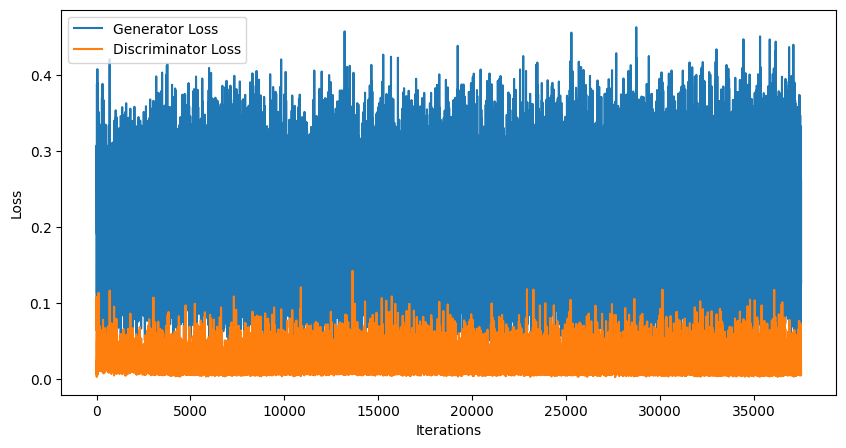

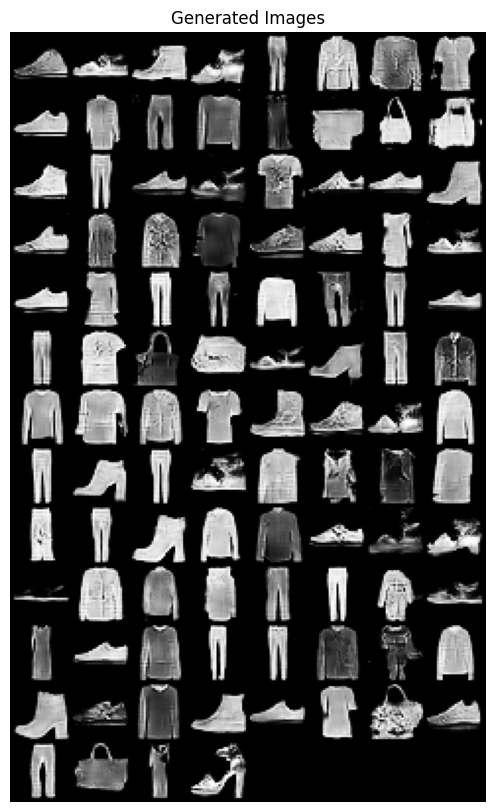

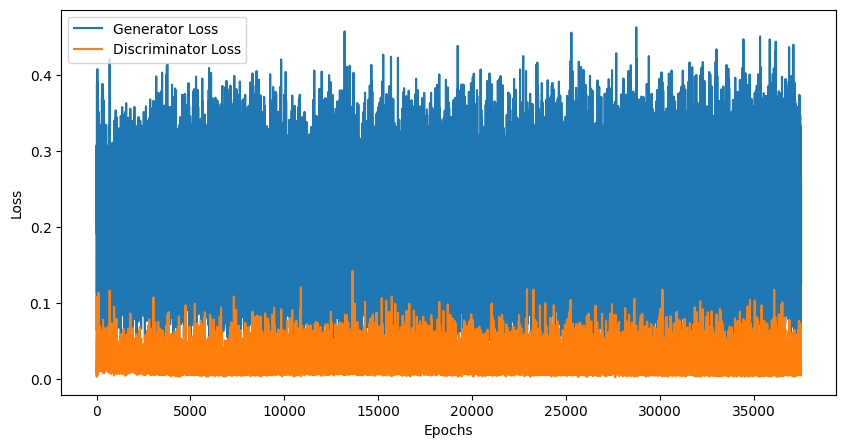

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils

# Set random seed for reproducibility
manual_seed = 42
torch.manual_seed(manual_seed)

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_dim=100, n_classes=10):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, 50)

        self.init_size = 7
        self.l1 = nn.Linear(latent_dim + 50, 128 * self.init_size ** 2)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_size=28, n_classes=10):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, img_size * img_size)

        self.model = nn.Sequential(
            nn.Conv2d(2, 64, 3, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),  
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        label_emb = self.label_embedding(labels)
        label_emb = label_emb.view(label_emb.size(0), 1, img.shape[2], img.shape[3])
        d_in = torch.cat((img, label_emb), 1)
        validity = self.model(d_in)
        return validity




# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def label_smoothing(labels, smoothing=0.1):
    rand_tensor = torch.rand(labels.size()).to(labels.device)
    return (1.0 - smoothing) * labels + smoothing * rand_tensor

# Training parameters
lr = 4e-4
lr_g = 1e-4
b1 = 0.5
b2 = 0.999
batch_size = 16  
latent_dim = 100
n_classes = 10
img_size = 28

# Loss function
adversarial_loss = nn.MSELoss()

# Initialize generator and discriminator
generator = Generator(latent_dim, n_classes)
discriminator = Discriminator(img_size, n_classes)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

generator.to(device)
discriminator.to(device)

# Initialize weights
generator.apply(weights_init)
discriminator.apply(weights_init)

# Configure data loader
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataloader = DataLoader(
    FashionMNIST("./data", train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Training Loop
n_epochs = 10  # Adjusted number of epochs
losses = {"G": [], "D": []}

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        smoothed_label_value = 0.75
        fake_label_value = 0.25
        valid = torch.full((imgs.size(0), 1), smoothed_label_value).to(device)
        fake = torch.full((imgs.size(0), 1), fake_label_value).to(device)
        

        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Sample noise and labels as generator input
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real images
        real_pred = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(real_pred, valid)

        # Measure discriminator's ability to classify fake images
        fake_pred = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = 0.5 * (d_real_loss + d_fake_loss)

        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        gen_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        losses["G"].append(g_loss.item())
        losses["D"].append(d_loss.item())

        
        if i % 50 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %.3f] [G loss: %.3f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

torch.save(generator.state_dict(), "./generator.pth")
torch.save(discriminator.state_dict(), "./discriminator.pth")

# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(losses["G"], label="Generator Loss")
plt.plot(losses["D"], label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Generate images
n_samples = 100
latent_points = torch.randn(n_samples, latent_dim).to(device)
labels = torch.randint(0, n_classes, (n_samples,)).to(device)
with torch.no_grad():
    gen_imgs = generator(latent_points, labels).cpu()

# Plot generated images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(gen_imgs[:100], padding=2, normalize=True).cpu(), (1, 2, 0)
    )
)
plt.show()





In [31]:
# for MNIST 

[Epoch 0/10] [Batch 0/3750] [D loss: 0.076] [G loss: 0.068]
[Epoch 0/10] [Batch 50/3750] [D loss: 0.012] [G loss: 0.263]
[Epoch 0/10] [Batch 100/3750] [D loss: 0.008] [G loss: 0.239]
[Epoch 0/10] [Batch 150/3750] [D loss: 0.034] [G loss: 0.325]
[Epoch 0/10] [Batch 200/3750] [D loss: 0.015] [G loss: 0.292]
[Epoch 0/10] [Batch 250/3750] [D loss: 0.076] [G loss: 0.166]
[Epoch 0/10] [Batch 300/3750] [D loss: 0.034] [G loss: 0.252]
[Epoch 0/10] [Batch 350/3750] [D loss: 0.035] [G loss: 0.259]
[Epoch 0/10] [Batch 400/3750] [D loss: 0.055] [G loss: 0.145]
[Epoch 0/10] [Batch 450/3750] [D loss: 0.017] [G loss: 0.186]
[Epoch 0/10] [Batch 500/3750] [D loss: 0.033] [G loss: 0.155]
[Epoch 0/10] [Batch 550/3750] [D loss: 0.039] [G loss: 0.139]
[Epoch 0/10] [Batch 600/3750] [D loss: 0.036] [G loss: 0.127]
[Epoch 0/10] [Batch 650/3750] [D loss: 0.026] [G loss: 0.189]
[Epoch 0/10] [Batch 700/3750] [D loss: 0.031] [G loss: 0.175]
[Epoch 0/10] [Batch 750/3750] [D loss: 0.026] [G loss: 0.129]
[Epoch 0/10

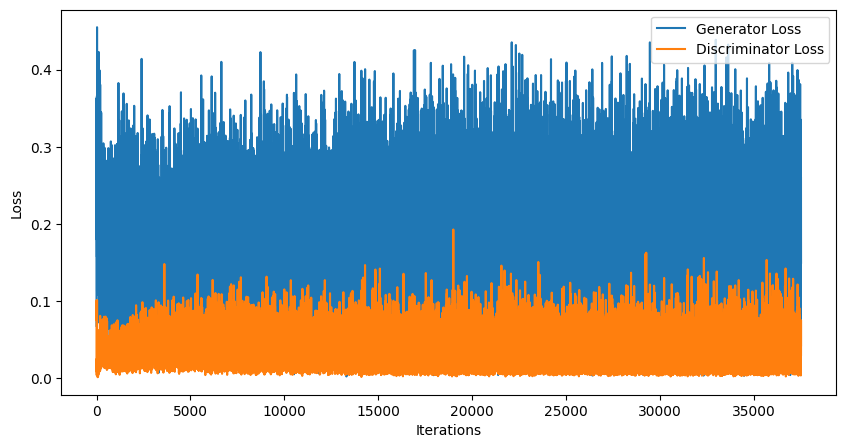

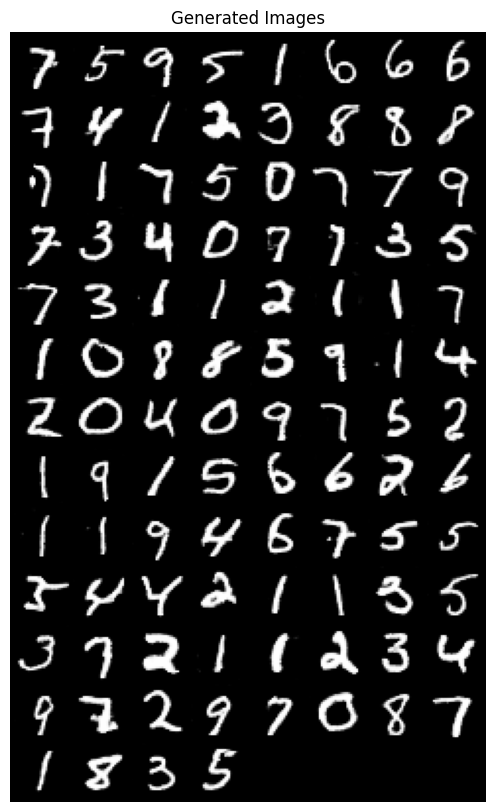

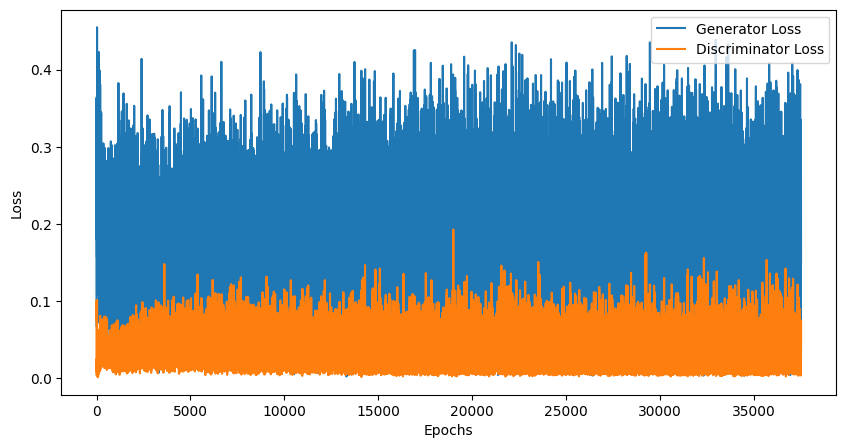

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils

# Set random seed for reproducibility
manual_seed = 42
torch.manual_seed(manual_seed)

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_dim=100, n_classes=10):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, 50)

        self.init_size = 7
        self.l1 = nn.Linear(latent_dim + 50, 128 * self.init_size ** 2)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_size=28, n_classes=10):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, img_size * img_size)

        self.model = nn.Sequential(
            nn.Conv2d(2, 64, 3, stride=2, padding=1),  # Change input channels to 2
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),  # Adjusted input size
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        label_emb = self.label_embedding(labels)
        label_emb = label_emb.view(label_emb.size(0), 1, img.shape[2], img.shape[3])
        d_in = torch.cat((img, label_emb), 1)
        validity = self.model(d_in)
        return validity




# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def label_smoothing(labels, smoothing=0.1):
    # Make sure the random tensor is on the correct device
    rand_tensor = torch.rand(labels.size()).to(labels.device)
    return (1.0 - smoothing) * labels + smoothing * rand_tensor

# Training parameters
lr = 4e-4
lr_g = 1e-4
 # Adjusted learning rate
b1 = 0.5
b2 = 0.999
batch_size = 16  # Adjusted batch size
latent_dim = 100
n_classes = 10
img_size = 28

# Loss function
adversarial_loss = nn.MSELoss()

# Initialize generator and discriminator
generator = Generator(latent_dim, n_classes)
discriminator = Discriminator(img_size, n_classes)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

generator.to(device)
discriminator.to(device)

# Initialize weights
generator.apply(weights_init)
discriminator.apply(weights_init)

# Configure data loader
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataloader = DataLoader(
    MNIST("./data", train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Training Loop
n_epochs = 10  # Adjusted number of epochs
losses = {"G": [], "D": []}

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        smoothed_label_value = 0.75
        fake_label_value = 0.25 # or another value representing smoothed "valid" labels
        valid = torch.full((imgs.size(0), 1), smoothed_label_value).to(device)
        fake = torch.full((imgs.size(0), 1), fake_label_value).to(device)
        # Adversarial ground truths
        # valid = torch.ones(imgs.size(0), 1).to(device)
        # fake = torch.zeros(imgs.size(0), 1).to(device)

        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Sample noise and labels as generator input
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real images
        real_pred = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(real_pred, valid)

        # Measure discriminator's ability to classify fake images
        fake_pred = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = 0.5 * (d_real_loss + d_fake_loss)

        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        gen_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # Save Losses for plotting later
        losses["G"].append(g_loss.item())
        losses["D"].append(d_loss.item())

        # Print progress
        if i % 50 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %.3f] [G loss: %.3f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

# Save the model checkpoints
torch.save(generator.state_dict(), "./generator.pth")
torch.save(discriminator.state_dict(), "./discriminator.pth")

# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(losses["G"], label="Generator Loss")
plt.plot(losses["D"], label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Generate images
n_samples = 100
latent_points = torch.randn(n_samples, latent_dim).to(device)
labels = torch.randint(0, n_classes, (n_samples,)).to(device)
with torch.no_grad():
    gen_imgs = generator(latent_points, labels).cpu()

# Plot generated images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(gen_imgs[:100], padding=2, normalize=True).cpu(), (1, 2, 0)
    )
)
plt.show()

# Graph of DCGAN loss vs. epoch
plt.figure(figsize=(10, 5))
plt.plot(losses["G"], label="Generator Loss")
plt.plot(losses["D"], label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

